# Value at Risk Calculation using SPARK

TEAM MEMBERS: Yasmine, Agata, Edem, Javier, Florian

The following Jupyter will explain our approach and walk through the different steps in deriving. The actual computations have been executed in both Anaconda Spyder and later in the Spark Virtual Environment that was provided to us. Code Snippets might reference CSV files, to re-run this project this has to be adjusted.

# Structure
## 1. Instruments
## 2. Factors
## 3. Model
## 4. Implementation in SPARK

In [1]:
import pandas as pd  
import os.path

# 1. Instruments

## 1.1 Create dataframe with the values of all instruments from the csv files 

### Read the directory where the csv files are saved
Files have been saved as local copies

In [5]:
path = '/Users/flo/Documents/GitHub/VaR-Calculation-SPARK/Instruments_data'  
filelist = os.listdir(path)

csv_inst_names = []

for i in filelist:
    csv_inst_names.append(i[:-4])

### Create daterange to merge with the values of all instruments afterwards
This allows us to control our custom defined date ranges as specified in the project and we can standardize that across instruments (We are starting with 12/16 so that we already have a return for the first Non-Holiday Day in 2008)

In [14]:
daterange = pd.date_range('2007-12-26','2019-01-31')
daterange = pd.DataFrame(data=daterange)
daterange.rename(columns={0: 'Date'}, inplace=True)

### Merge daterange with the instruments, drop weekends and fill holidays with values from previous day
As we are interested in returns over a given period of time, we decided to remove weekends. For example, on a Monday the count for the return over 5 past days would start on the last trading Day, Friday. Additionally, we have a lot of holidays and missing values across datasets. For them, we apply a similar logic - Filling the blank with the last previous available value.

In [7]:
instruments = daterange.copy()

#We have started with a instrument file that only contains the dates, now we can add a column for each instrument

for i in csv_inst_names:
    instrument = pd.read_csv('/Users/flo/Documents/GitHub/VaR-Calculation-SPARK/Instruments_data/{}.csv'.format(i))
    instrument = instrument[['timestamp','close']]
    instrument.rename(columns={'timestamp': 'Date'}, inplace=True)
    instrument.rename(columns={'close': i}, inplace=True)    
    instrument['Date'] = pd.to_datetime(instrument.Date)
    instruments = pd.merge(instruments, instrument, how='left', on=['Date'])

instruments['Date'] = instruments['Date'].dt.date

instruments['Weekday'] = pd.DatetimeIndex(instruments['Date']).weekday
instruments['Weekend'] = instruments['Weekday'].map(lambda x: 1 if x == 5.0 or x == 6.0 else 0)
instruments = instruments[instruments['Weekend'] != 1]
instruments = instruments.reset_index()
instruments = instruments.drop('index', 1)
instruments = instruments.fillna(method='ffill')


### Convert values to numeric to allow further calculations

In [8]:
cols = instruments.columns.drop('Date')
instruments[cols] = instruments[cols].apply(pd.to_numeric, errors='coerce')

## 1.2. Calculating 5 days returns of each instrument

We now have a Pandas datframe with the values of all the instruments. The next step involves converting these into returns. As per instructions, we are using the following formula: <br>
(price(day) – price(day – 5)) / price(day – 5)  <br>
We are creating a new column with returns for each, so that we can calculate the value for each day, based on the PRICES of the last 5 days


In [9]:
returns_instruments = instruments.drop('Weekday', 1)
returns_instruments = returns_instruments.drop('Weekend', 1)

for column in returns_instruments:
    if column == 'Date':
        continue
    for index, row in returns_instruments.iterrows():
            if index < 5:
                continue
            else:    
                returns_instruments.loc[index, 'Return ' + column] = (returns_instruments.loc[index, column] - returns_instruments.loc[index-5, column]) / returns_instruments.loc[index-5, column]

returns_instruments = returns_instruments[['Date', 'Return daily_DGLD', 'Return daily_MDRX', 'Return daily_HAWK',
       'Return daily_DOX', 'Return daily_EGHT', 'Return daily_CFFI',
       'Return daily_JOBS', 'Return daily_FCCY', 'Return daily_CHRW',
       'Return daily_TWOU', 'Return daily_CRMT', 'Return daily_INBK',
       'Return daily_XLRN', 'Return daily_AVHI', 'Return daily_MULT',
       'Return daily_MTGE', 'Return daily_VNET', 'Return daily_QABA',
       'Return daily_FUBC', 'Return daily_KOOL', 'Return daily_BCOM',
       'Return daily_ABAX', 'Return daily_FLWS', 'Return daily_PLCE',
       'Return daily_HTHT', 'Return daily_GOOG', 'Return daily_DAEG',
       'Return daily_AEGR', 'Return daily_CHOP', 'Return daily_DJCO',
       'Return daily_EPAX', 'Return daily_JRJC', 'Return daily_SRCE',
       'Return daily_UHAL', 'Return daily_YPRO', 'Return daily_SATS',
       'Return daily_HGSH', 'Return daily_IMOS', 'Return daily_ACTA',
       'Return daily_FTLB', 'Return daily_SHLM', 'Return daily_HOTR',
       'Return daily_BIRT', 'Return daily_WATT', 'Return daily_PIH',
       'Return daily_BOSC', 'Return daily_FCTY', 'Return daily_AAON',
       'Return daily_FOLD']]

returns_instruments = returns_instruments[5:]

## 1.3. Check Start date and End date for each instrument and Remove instruments with no data until 31 Jan 2019. Generate file containing only the instruments with data until 31 Jan 2019.
So far, we have looked at our instruments only from a coding, not from a finance perspective. No we will add the finance view. We decided to remove all instruments that did not have values in 2019. Our assumption here is that if the instrument is not listed any more on the stock market, there is no return benefit to the portfolio, as we want to make predictions for the future and not the past. We have outputed the ones that we removed below:

In [10]:
final_columns = ['Date']

for i in csv_inst_names:

    instru = pd.read_csv('/Users/flo/Documents/GitHub/VaR-Calculation-SPARK/Instruments_data/{}.csv'.format(i))

    if max(instru['timestamp']) < '2019-01-31':
        print(i[6:])
        print('Start date: ', min(instru['timestamp']))
        print('End date: ', max(instru['timestamp']), '\n')
        print( i[6:], ' no data until 31-Jan-19 \n')
    else:
        final_columns.append('Return '+ i)

returns_instruments = returns_instruments[final_columns]

HAWK
Start date:  2013-04-19
End date:  2018-06-25 

HAWK  no data until 31-Jan-19 

AVHI
Start date:  2003-05-23
End date:  2018-10-02 

AVHI  no data until 31-Jan-19 

MULT
Start date:  2014-07-09
End date:  2015-10-30 

MULT  no data until 31-Jan-19 

MTGE
Start date:  2011-08-04
End date:  2018-09-07 

MTGE  no data until 31-Jan-19 

FUBC
Start date:  2008-04-10
End date:  2014-10-31 

FUBC  no data until 31-Jan-19 

ABAX
Start date:  1998-01-02
End date:  2018-08-01 

ABAX  no data until 31-Jan-19 

DAEG
Start date:  1998-01-02
End date:  2015-11-20 

DAEG  no data until 31-Jan-19 

AEGR
Start date:  2010-10-21
End date:  2016-12-07 

AEGR  no data until 31-Jan-19 

CHOP
Start date:  2007-04-17
End date:  2015-11-24 

CHOP  no data until 31-Jan-19 

EPAX
Start date:  2002-03-01
End date:  2015-10-23 

EPAX  no data until 31-Jan-19 

YPRO
Start date:  2016-01-04
End date:  2016-11-01 

YPRO  no data until 31-Jan-19 

ACTA
Start date:  1999-08-05
End date:  2018-04-20 

ACTA  no dat

## 1.4. Generate file containing only the instruments with data until 31 Jan 2019.
The final step for the Instruments involves saving the pandaframe locally, so that we can access it quicker for future computation


In [11]:
#returns_instruments.to_csv('/Users/javierfdz/Documents/GitHub/VaR-Calculation-SPARK/Instruments_returns.csv', index=False)

# 2. Factors

In [12]:
import urllib.request as url
import numpy as np
import pandas as pd


factor1url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%5eGSPC&outputsize=full&apikey=CAJH46WI0QYW2RGK&datatype=csv'
factor2url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=NDAQ&outputsize=full&apikey=CAJH46WI0QYW2RGK&datatype=csv'
factor3url = 'https://www.quandl.com/api/v3/datasets/OPEC/ORB/data.csv?start_date=2007-12-26&end_date=2019-01-31&api_key=LwmAyD-1JHAzhMKKSvDX'
factor4url = 'https://www.quandl.com/api/v3/datasets/USTREASURY/YIELD.csv?start_date=2007-12-26&end_date=2019-01-31&api_key=LwmAyD-1JHAzhMKKSvDX'



alphaurls = {"Factor 1":factor1url,"Factor 2":factor2url}
quandlurls = {"Factor 3":factor3url,"Factor 4":factor4url}

## In the following, we will create dataframes for Factor 1 & 2
We have to split 1 & 2 - 2&3 Factors as the APIs use a different json format

In [13]:
#Creating DF for Factor 1 & 2

lst = []
for i in alphaurls:
    remoteFile = url.urlopen(alphaurls[i])
    html = remoteFile.read().decode('ascii').splitlines()
    b = pd.DataFrame(data=html)
    b = b[0].str.split(",", expand = True)
    b.columns = b.iloc[0]
    b = b[1:]
    final = b[['timestamp','close']]
    final = final[final['timestamp'] >= '2007-12-26']
    final.rename(columns={'close': i}, inplace=True) 
    final.rename(columns={'timestamp': 'Date'}, inplace=True) 
    final['Date'] = pd.to_datetime(final.Date)
    lst.append(final)
factor1_2 = pd.merge(lst[0], lst[1], how='outer', on=['Date']) 

## We then create a daterange manually, which will help us control the start date  and end date of the dataframes and manipulate weekends
This is the same approach as previoulsy with the instruments

In [15]:
#Adding a custom daterange to account for holidays etc that are different in datasets

daterange = pd.date_range('2007-12-26','2019-01-31')
daterange = pd.DataFrame(data=daterange)
daterange.rename(columns={0: 'Date'}, inplace=True) 

#Mapping for weekends
daterange['Weekday'] = pd.DatetimeIndex(daterange['Date']).weekday
daterange['Weekend'] = daterange['Weekday'].map(lambda x: 1 if x == 5.0 or x == 6.0 else 0)


merged = pd.merge(daterange, factor1_2, how='left', on=['Date'])
merged['Date'] = merged['Date'].dt.date

## Adding Factor 3 & 4
For the bonds we had to make another uce case related decision. As per assignment instruction we did not know about the timeframe of the portfolio, we decided to take the average of the different provided Bonds values ( 1 Mo, 3 Mo, 1 yr. etc)

In [16]:
#%% Adding Factor 3

remoteFile = url.urlopen(factor3url)
html = remoteFile.read().decode('ascii').splitlines()
b = pd.DataFrame(data=html)
b = b[0].str.split(",", expand = True)
b.columns = b.iloc[0]
b = b[1:]
factor3 = b[b['Date'] >= '2007-12-26']
factor3.rename(columns={'Value': 'Factor 3'}, inplace=True) 
factor3 = factor3.sort_values(by='Date').reset_index()
factor3 = factor3.drop("index",1)
factor3['Date'] = pd.to_datetime(factor3.Date)
factor3['Date'] = factor3['Date'].dt.date

merged_1_2_3 = pd.merge(merged, factor3, how='left', on=['Date'])


#%%

#Factor 4 - taking the average of all different bonds as one factor


remoteFile = url.urlopen(factor4url)
html = remoteFile.read().decode('ascii').splitlines()
b = pd.DataFrame(data=html)
b = b[0].str.split(",", expand = True)
b.columns = b.iloc[0]
b = b[1:]
factor4 = b[b['Date'] >= '2007-12-26']
factor4['average'] = factor4[['1 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR',
       '7 YR', '10 YR']].apply(pd.to_numeric).mean(axis=1)
factor4.rename(columns={'average': 'Factor 4'}, inplace=True) 
factor4['Date'] = pd.to_datetime(factor4.Date)
factor4['Date'] = factor4['Date'].dt.date
factor4  = factor4[['Date','Factor 4']]



merged_1_2_3_4 = pd.merge(merged_1_2_3, factor4, how='left', on=['Date'])

## Now we have combined all 4 factors, but we still have weekends and holidays in there. First we want to remove weekends:

In [17]:
merged_1_2_3_4 = merged_1_2_3_4[merged_1_2_3_4['Weekend'] != 1]

## As we noticed that different factors had different missing dates (holidays etc), we cannot generalize this. We fill missing values with the previous day / last "non-nan" day

In [18]:
merged_1_2_3_4 = merged_1_2_3_4.fillna(method='ffill')

## Next step is to convert factors to returns:

In [21]:
#Adding Factors with square and root

X= merged_1_2_3_4

X['Factor 1']= pd.to_numeric(X['Factor 1'])
X['Factor 2']= pd.to_numeric(X['Factor 2'])
X['Factor 3']= pd.to_numeric(X['Factor 3'])
X['Factor 4']= pd.to_numeric(X['Factor 4'])


#%% Codes to calculate returns from prices 

returns_factors = X.reset_index()
returns_factors = returns_factors[['Date', 'Factor 1', 'Factor 2', 'Factor 3', 'Factor 4']]



for index, row in returns_factors.iterrows():
        if index < 5:
            continue
        else:    
            returns_factors.loc[index, 'Return1'] = (returns_factors.loc[index, 'Factor 1'] - returns_factors.loc[index-5, 'Factor 1']) / returns_factors.loc[index-5, 'Factor 1']
for index, row in returns_factors.iterrows():
        if index < 5:
            continue
        else:    
            returns_factors.loc[index, 'Return2'] = (returns_factors.loc[index, 'Factor 2'] - returns_factors.loc[index-5, 'Factor 2']) / returns_factors.loc[index-5, 'Factor 2']

for index, row in returns_factors.iterrows():
        if index < 5:
            continue
        else:    
            returns_factors.loc[index, 'Return3'] = (returns_factors.loc[index, 'Factor 3'] - returns_factors.loc[index-5, 'Factor 3']) / returns_factors.loc[index-5, 'Factor 3']

for index, row in returns_factors.iterrows():
        if index < 5:
            continue
        else:    
            returns_factors.loc[index, 'Return4'] = (returns_factors.loc[index, 'Factor 4'] - returns_factors.loc[index-5, 'Factor 4']) / returns_factors.loc[index-5, 'Factor 4']


#%%
            
returns_factors = returns_factors.dropna().reset_index()
final_factors =   returns_factors[['Date','Return1','Return2','Return3','Return4']]

# Checking with Shapiro Test & KDE that Returns of Factors are normally distributed
We used Shapiro-Wilk test to prove normality of distribution. The Shapiro-Wilk tests if a random sample came from a normal distribution. The null hypothesis of the test is the data is normally distributed. If the p value returned is less than.05, then the null hypothesis is rejected and there is evidence that the data is not from a normally distributed population.

However, It is completely possible that for p > 0.05 and the data does not come from a normal population. Failure to reject could be from the sample size being too small to detect the non-normality. So, keep this in mind when interpreting the results.
As well the stats.shapiro method will throw a warning on samples for size > 5000. So, for data sets larger than that you might want to choose another test for normality. But our data sample for each factor was just under 5000 so suitable for the test. We backed it up by using histogram for visualisation.


0.9129024744033813
this is W static
6.784675743031638e-38
this is p value
0.8830986618995667
this is W static
2.888076134973448e-42
this is p value
0.9588468670845032
this is W static
6.990171881320708e-28
this is p value
0.9765915274620056
this is W static
2.0837953924562625e-21
this is p value


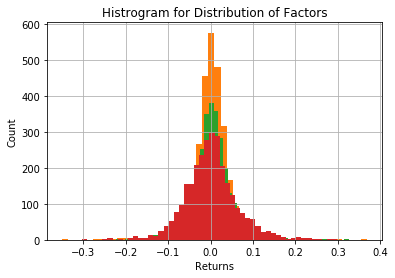

In [52]:
#%% Preparing returns dataframe for the distribution test
Returnsfactor1 = final_factors['Return1']
Returnsfactor2 = final_factors['Return2']
Returnsfactor3 = final_factors['Return3']
Returnsfactor4 = final_factors['Return4']

#%% Proving that the each factor returns are normally distributed via Shapiro test


from scipy import stats
import matplotlib.pyplot as plt

Shapirotest1= (stats.shapiro (Returnsfactor1))
print (Shapirotest1[0])
print ("this is W static")
print (Shapirotest1[1])
print ("this is p value")

Shapirotest2= (stats.shapiro (Returnsfactor2))
print (Shapirotest2[0])
print ("this is W static")
print (Shapirotest2[1])
print ("this is p value")

Shapirotest3= (stats.shapiro (Returnsfactor3))
print (Shapirotest3[0])
print ("this is W static")
print (Shapirotest3[1])
print ("this is p value")

Shapirotest4= (stats.shapiro (Returnsfactor4))
print (Shapirotest4[0])
print ("this is W static")
print (Shapirotest4[1])
print ("this is p value")

histFact1 = Returnsfactor1.hist(bins=50)
histFact2 = Returnsfactor2.hist(bins=50)
histFact3 = Returnsfactor3.hist(bins=50)
histFact4 = Returnsfactor4.hist(bins=50) 

plt.title('Histrogram for Distribution of Factors')
plt.xlabel('Returns')
plt.ylabel('Count')
plt.show()

We used Shapiro test to check normality of distribution of factor returns and histogram. However because of the high volatility of factors we should smoothen up the histogram using the Kernel density estimation (KDE) technique. To estimate the probability density at a given point, KDE evaluates the Probability distribution functions of all the normal distributions at that point and takes their average. Source of this approach: https://perso.telecom-paristech.fr/qleroy/aml/lab4.html

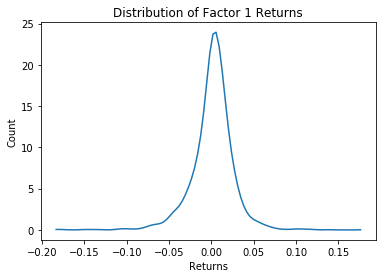

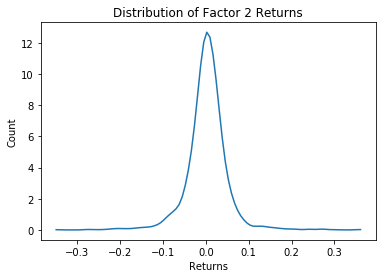

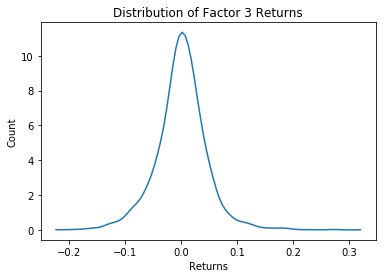

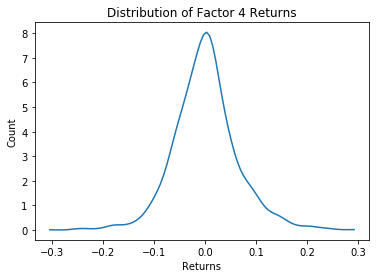

In [51]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.pyplot as plt
import scipy

def plotDistribution(samples, title, numSamples=100):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/numSamples)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    plt.plot(domain, density)
    plt.title(title)
    plt.xlabel('Returns')
    plt.ylabel('Count')
    plt.show()
    

plotDistribution(Returnsfactor1,'Distribution of Factor 1 Returns')
plotDistribution(Returnsfactor2,'Distribution of Factor 2 Returns')
plotDistribution(Returnsfactor3,'Distribution of Factor 3 Returns')
plotDistribution(Returnsfactor4,'Distribution of Factor 4 Returns')

## Featurizing Factors



## We make sure that we do not change the sign of the returns when applying modifications like squaring or squared root

In [65]:
#Featurizing Factors

featurized = final_factors.copy()

featurized['Factor 1 S'] = featurized['Return1'].apply(lambda x: -(x**2) if (x < 0) else x**2)

featurized['Factor 2 S'] = featurized['Return2'].apply(lambda x: -(x**2) if (x < 0)else x**2)

featurized['Factor 3 S'] = featurized['Return3'].apply(lambda x: -(x**2) if (x < 0) else x**2)

featurized['Factor 4 S'] = featurized['Return4'].apply(lambda x: -(x**2) if (x < 0) else x**2)

featurized['Factor 1 R'] = featurized['Return1'].apply(lambda x: -(abs(x)** (1/2)) if (x < 0) else x** (1/2))

featurized['Factor 2 R'] = featurized['Return2'].apply(lambda x: -(abs(x)** (1/2)) if (x < 0) else x** (1/2))

featurized['Factor 3 R'] = featurized['Return3'].apply(lambda x: -(abs(x)** (1/2)) if (x < 0) else x** (1/2))

featurized['Factor 4 R']= featurized['Return4'].apply(lambda x: -(abs(x)** (1/2)) if (x < 0) else x** (1/2))



csv_factors = featurized[['Date','Return1','Return2','Return3','Return4','Factor 1 S','Factor 2 S','Factor 3 S','Factor 4 S','Factor 1 R','Factor 2 R','Factor 3 R','Factor 4 R']]
csv_factors.rename(columns={'Return1': 'Factor1'}, inplace=True) 
csv_factors.rename(columns={'Return2': 'Factor2'}, inplace=True) 
csv_factors.rename(columns={'Return3': 'Factor3'}, inplace=True) 
csv_factors.rename(columns={'Return4': 'Factor4'}, inplace=True) 
csv_factors.rename(columns={'Factor 1 S': '1S'}, inplace=True) 
csv_factors.rename(columns={'Factor 2 S': '2S'}, inplace=True) 
csv_factors.rename(columns={'Factor 3 S': '3S'}, inplace=True) 
csv_factors.rename(columns={'Factor 4 S': '4S'}, inplace=True) 
csv_factors.rename(columns={'Factor 1 R': '1R'}, inplace=True) 
csv_factors.rename(columns={'Factor 2 R': '2R'}, inplace=True) 
csv_factors.rename(columns={'Factor 3 R': '3R'}, inplace=True) 
csv_factors.rename(columns={'Factor 4 R': '4R'}, inplace=True) 



#csv_factors.to_csv (r'/Users/flo/Documents/GitHub/VaR-Calculation-SPARK/factors/factorfile.csv', index=False)

Now we have featurized the factored to account for non-linear relationship. Whether or not the chosen approach with the root and the square. Simlar to the instruments we are also saving the factors as a local copy to access it for the next step.

# 3. MODEL
No we can start with the modelling - As per instructions, we choose a simple linear model.
We first import the 2 datasets for factors & instruments

In [66]:
import pandas as pd
from sklearn import linear_model
import numpy as np

factors = pd.read_csv('/Users/flo/Documents/GitHub/VaR-Calculation-SPARK/factors/factorfile.csv')
instruments = pd.read_csv('/Users/flo/Documents/GitHub/VaR-Calculation-SPARK/instruments_returns.csv')

covariance = factors[['Factor1','Factor2','Factor3','Factor4']].cov()
mean = factors[['Factor1','Factor2','Factor3','Factor4']].mean()

model = linear_model.LinearRegression()

## Model Fitting

We took the following assumption from the instrucions: <br>

The method is based in the assumption that we can estimate the return of the
portfolio as function of a set of market factors.
𝑟𝑖 = 𝑐𝑖 + ∑𝑤𝑖𝑗 ∗ 𝑓𝑗
Where r = returns and f = factor

In the following, we will use the sciKit learn model.fit function, fit a model on each instrument and generate a list that contains the respective weight and y intercepts. For visualization purposes, we will do this in "pure" python with the respective libraries - later one we will show the adapted approach fit for SPARK.

In [67]:
#First, instead of just fitting the model we will extract the coefficients opf each linear model

weights = []
intercepts = []

for column in instruments:
    if column == 'Date':
            continue    
     #We are doing another left join with the specific instrument data series and the factors, 
     #in order to adjust the length of the factors date range to the speicific instrument
    datarange = instruments[['Date',column]].dropna().reset_index()
    dataset =  pd.merge(datarange, factors, how='inner', on=['Date'])
    X = dataset[['Factor1','1S','1R','Factor2','2S','2R','Factor3','3S','3R','Factor4','4S','4R']]
    y = dataset[column]    
        
    model.fit(X,y)
    
    weights.append(model.coef_)
    intercepts.append(model.intercept_)
    



## We now have a list of arrays with the respective weights for the 4 factors for all instruments as well as a list with one y-intercept for each instrument

At this point, we want to briefly discuss the implication of our model fitting. While in the scope of this project we do not have to evaluate different models and the potential fit, we can make some statements about the general underlying assumptions. Right now, we are fitting a linear model for 30 + different instruments that we have received: We are working with the assumption that these instruments behave similar and underly the same external impact. 2nd, we also assume that the chosen time horizon is a good represenation of the stock behaviour in 2019: We would recommend analyzing the historical trend more and choose a shorter time horizon potentially. 3rd, we have 1000s of data points, but only 4 factors that we featurize - This is a very basic assumption and in real life, a stock behaviour would depend on many additional factors that we would need to include. Also, the factors are correlated (as shown below), hence the additional benefit of having these 4 is not as big as including another external factor that is not correlated to the 4 market factors. Using few variables to predict behaviours of many instruments is challenging. Some factors were pretty redundant & increasing featurisation of Factors 1,2 rather than all 4 could be more targeted

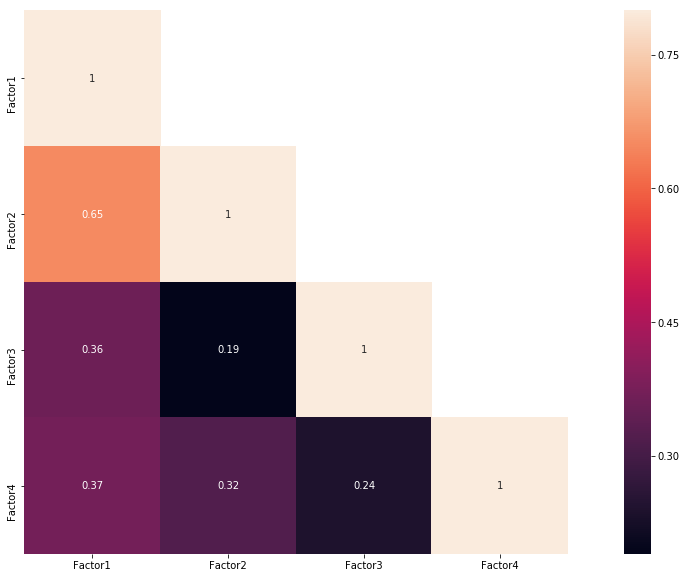

In [31]:
import seaborn as sns


corrMatt = factors.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt.round(2), mask=mask,vmax=.8, square=True,annot=True)

## We will use the same approach as earlier to featurize factors, this time we are adding it to a function, to re-use it later

In [68]:
def sign(number):
    if number<0:
        return -1
    else:
        return 1

def featurize(factorReturns):
    factorReturns = list(factorReturns)
    squaredReturns = [sign(element)*(element)**2 for element in factorReturns]
    squareRootedReturns = [sign(element)*abs(element)**0.5 for element in factorReturns]
    # concat new features
    return squaredReturns + squareRootedReturns + factorReturns

## Next Step: Creating a function to generate samples for function in a loop and predict returns of portfolio
For a better understanding, approach is explained detailled, in-line, the general approach is as follows: <br>
1) Generate Samples <br>
2) Featurized Samples <br>
3) Multiply each entry in the weights list with the factors and sum them, then add the intercept to get the return <br>
4) Add the return of the instrument to the list for each portfolio and take the average - then add that value to the list of all portfolios


In [69]:
def simulate(runs, weights, intercepts):
    #The function takes 3 parameters, the number of runs that we want and the weights and intercepts that we generated above
    returns = []
    for i in range(runs):
        # We are generating sample values for our 4 factors based on mean and covariance of historical dataset
        samples = np.random.multivariate_normal(mean, covariance)
        # we can then call our featurize function from above:
        featurized_factors = featurize(samples)
        portfolio_return = 0
        # Now we need to caluclate the return of each instrument
        #We have 3 lists to work with, the list of featurized random factors, the lists within a list of weights and the list of intercepts:
        for index, weightlst in enumerate(weights):
            for index2, factor in enumerate(featurized_factors):
                # We multiply the respective factor with the respective weight and add the intercept for that instrument
                inst_return = sum([factor * weightlst[index2]]) + intercepts[index]
                portfolio_return += inst_return
        returns.append(portfolio_return)  
    return returns

# We return a list that now contains the estimate portfolio return for each run where we generate the factors

Text(0,0.5,'Count')

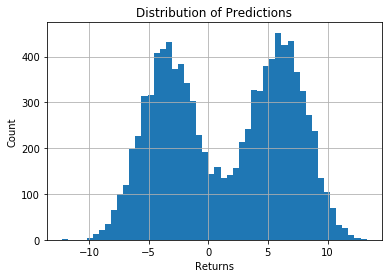

In [70]:
predictions = simulate(10000,weights, intercepts)

# Now we can show, that the predictions follow a multivariate normal distribution:

predictions_df = pd.DataFrame(data=predictions)
predictions_df.hist(bins=50)
plt.title('Distribution of Predictions')
plt.xlabel('Returns')
plt.ylabel('Count')




# Calculating Value at Risk
For the VAR calculation we apply the following steps: <br>
1) We sort the list of all returns first <br>
2) We slice the list at the 5th percentile from the bottom <br>
3) We take the max ("least negative") from that slice <br>

In [71]:
# And we can calculate the VAR
predictions.sort()
n = len(predictions)*0.05
five_percent = predictions[:int(n)]


#Result:
var = max(five_percent)
print('VAR: ' + str(var))

VAR: -6.25354669498154


As a result, we can see that we have calculated a VAR of -6.25 of Total Portfolio

# 4. Implementation in SPARK

The approach above has been very much oriented at Python, using the Pandas libraries that we are familiar with and only after doing that we approached the next step: Parallizing this in Spark.  

From our research, we could see three options to make our current computation of the trial runs work in Spark:

1) In general, Spark is parallelizing nativeley if the respective Spark libraries are used ---> E.g by using Spark RDD Dataframes, Spark is automatically distributing the computation across the clusters. 
1) Using multithreading libraries
2) Using Pandas UDFs libraries to distribute Panda Dataframes

We decided to go for option one - which means converting our Pandas DF logic to Spark RDDs - Also, we need to use the SPARK ML linear model instead of the Scikit one.
<br>
The different Code Snippets below cannot be run in a normal Jupyter or Python environment - But have to be copied to a python file within a Spark environment that has the necessary packages installed. 

### Step 1: Initializing Spark Session
We are runnning our file in the virtual environemnt that was provided to us. 
With "touch VAR.py" we created an empty python file and also pip installed Pandas in the VE (as we do need some functionalities)

In [ ]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

import pandas as pd
import numpy as np
from pyspark.ml.regression import LinearRegression
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler


sc= SparkContext()
sqlContext = SQLContext(sc)

### Step 2: Importing Datafiles
After importing and initializing the Spark Session, we need to import the datafiles (We uploaded them to github and used wget to import them into the VE). We use Pyspark syntax to import the two csvs as Spark RDDs

In [ ]:
factors = sqlContext.read.format('csv').options(header='true', inferschema='true').load('factorfile.csv.1')
factors = factors.toPandas()

instruments = sqlContext.read.format('csv').options(header='true', inferschema='true').load('Instruments_returns.csv.1')
instruments = instruments.toPandas()


covariance = factors.cov()
mean = factors.mean()

weights = []
intercepts = []


### Step 3: Fitting Spark Linear Model & Deriving Coefficents
There is a  difference between the Scikit Learn linear model and the Spark ML Linear Regression --> in Spark, we cannot use the dataframes as input vectors, but need to create a map first with features and respective labels that can be transformed with the Spark linear model. We are using Spark Vector Assembler to faciliate that mapping.

In [ ]:
for column in instruments:
            if column == 'Date':
                continue
            datarange = instruments[['Date',column]].dropna().reset_index()
            dataset =  pd.merge(datarange, factors, how='inner', on=['Date'])
            X = dataset[['Factor1','1S','1R','Factor2','2S','2R','Factor3','3S','3R','Factor4','4S','4R']].values
            y = dataset[column].values
            spark_df = sqlContext.createDataFrame(dataset)
            print(spark_df.columns)

            #Fit the model on each instrument individually
            #We first have to transform our dataframes into a vector map as input parameters to the Linear Regression
            vectorAssembler = VectorAssembler(inputCols = [['Factor1','1S','1R','Factor2','2S','2R','Factor3','3S','3R','Factor4','4S','4R']], outputCol = 'features')
            vector_dataset = vectorAssembler.transform(spark_df)
            vector_dataset_train = vector_dataset.select(['features', column])
            model = LinearRegression(featuresCol = 'features', labelCol=column,regParam=0.3)
            lr_fitted = model.fit(vector_dataset_train)
            
            weights.append(lr_fitted.coefficients)
            intercepts.append(lr_fitted.intercept)
            
            

The above steps do not have to be parallelized but can be performed once to output the weights/coefficients and intercept lists. These could then be stored locally and imported whenever necessary.

### Step 4: Adding Function to simulate the runs that will then be parallelized
These are the same functions as previously used

In [ ]:
def sign(number):
    if number<0:
        return -1
    else:
        return 1

def featurize(factorReturns):
    factorReturns = list(factorReturns)
    squaredReturns = [sign(element)*(element)**2 for element in factorReturns]
    squareRootedReturns = [sign(element)*abs(element)**0.5 for element in factorReturns]
    # concat new features
    return squaredReturns + squareRootedReturns + factorReturns



# Now we have our basis set, without any pandas logic, and we can write the function that we want to parallelize i Spark
    
def simulate(runs,weights, intercepts):
    returns = []
    for i in range(runs):
        samples = np.random.multivariate_normal(mean, covariance)
        # we can then call our featurize function from above:
        featurized_factors = featurize(samples)
        portfolio_return = 0
        # Now we need to caluclate the return of each instrument
        #We have 3 lists to work with, the list of featurized random factors, the lists within a list of weights and the list of intercepts:
        for index, weightlst in enumerate(weights):
            for index2, factor in enumerate(featurized_factors):
                # We multiply the respective factor with the respective weight and add the intercept for that instrument
                inst_return = sum([factor * weightlst[index2]]) + intercepts[index]
                portfolio_return += inst_return
        returns.append(portfolio_return)  
    return returns

### Step 5: Parallelizing
There are different methods to initiate the parallelization - These also depend on the configuration of the Spark environment. We oriented the Spark syntax to distribute the computing, after an approach referenced here:https://perso.telecom-paristech.fr/qleroy/aml/lab4.html. <br>
Parallelized collections are created by calling SparkContext’s parallelize method. The elements of the collection are copied to form a distributed dataset that can be operated on in parallel.
By applying the seedRDD.flatMap function we are able to apply the function we have defined above to the be executed and the 10000 trials are split between them --> The function "simulate" defined above will be ran 12 times in parallel. You can add print statements in the function to validate this.
We also need to change the method to calculate VAR, as the difference of the SPARK implementation is that by parallelizing we return a SPARK RDD that does not have the method sort() as in pure python. The respective function for that is takeOrdered.

In [ ]:
def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(int(numTrials/20), 1))
    return topLosses[-1]                


if __name__ == "__main__":
    
    parallelism = 12
    numTrials = 10000
    trial_indexes = list(range(0, parallelism))

    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)
    
    #Below we are now creating the partitions with the flat map, deviding the trials to be executed between the worker Cores

    predictions = seedRDD.flatMap(lambda idx: \
                simulate(
                    max(int(numTrials/parallelism), 1),
                    weights,
                    intercepts
                ))
    predictions.cache()

    var = fivePercentVaR(predictions)
    print('VAR: ' + str(var))

That was our approach for the implementation, first in python, then in Spark. <br> 
Thanks a lot for following along! Best, Team A <br>
March 18th, 2019